<a href="https://colab.research.google.com/gist/Mlosyakov/b53db191da30c4bacf05ff01c758cae5/final_project_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Course project "Python and ML basics"

# Part 1. kNN method implementation using numpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.io as io
from pathlib import Path
import requests
from tqdm import tqdm
from scipy.spatial.distance import cdist


class SVHNLoader(): 
    def __init__(self, download=False): #default "False" prevents excess downloads
        if download:
            train_url = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
            test_url = "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
            for url in (train_url, test_url):
                self.download_data(url, verbose=True)
    
    #this method is the last step of getting data from given url
    
    #this method mainly cuts numpy arrays into test and train datasets   

    def get_data(self, max_train=1000, max_test=100):
        train_X, train_y = self.load_data_mat("train_32x32.mat", max_train) #max_train  - number of samples for training
        test_X, test_y = self.load_data_mat("test_32x32.mat", max_test)  #max_test - same for testing samples
        return train_X, train_y, test_X, test_y

    #this method is the first step in getting data

    #method for downloading and extracting data from url

    @staticmethod
    def download_data(url, verbose=False):
        filename = url.split('/')[-1]    #getting filemname from url using slices
        print(f"Downloading {filename}")
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(filename, 'wb') as f:   #opening files 
                for chunk in tqdm(r.iter_content(chunk_size=8192)):
                    f.write(chunk)
        return filename

    #this method is the second step in extracting data from url
    
    #"converting" .mat files to numpy arrays for get_data method
    
    def load_data_mat(self, filename, max_samples, seed=42):
        '''
        Loads numpy arrays from .mat file

        Returns:
        X, np array (num_samples, 32, 32, 3) - images
        y, np array of int (num_samples) - labels
        '''
        raw = io.loadmat(filename)
        X = raw['X']  # Array of [32, 32, 3, n_samples]
        y = raw['y']  # Array of [n_samples, 1]
        X = np.moveaxis(X, [3], [0])
        y = y.flatten()

        # Fix up class 0 to be 0
        y[y == 10] = 0

        #choosing random samples from dataset based on max_samples
        
        np.random.seed(seed)
        samples = np.random.choice(np.arange(X.shape[0]), max_samples, replace=False)
        return X[samples].astype(np.float32), y[samples]

## Downloading and visualisation of data


Dataset used in project: Street View House Numbers (SVHN, http://ufldl.stanford.edu/housenumbers/).

In [2]:
svhn = SVHNLoader(download=True)
train_X, train_y, test_X, test_y = svhn.get_data()

22222it [01:31, 244.09it/s]


7847it [00:30, 254.89it/s]


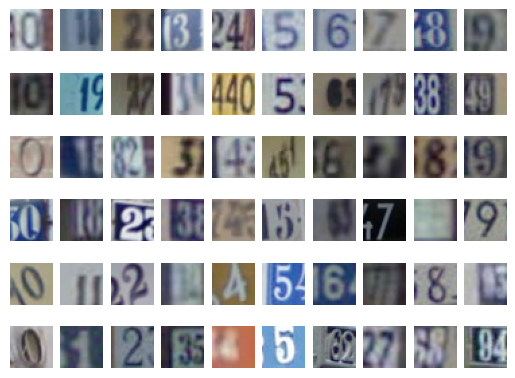

In [3]:
#this plot visualises train dataset

samples_per_class = 6  # Number of samples per class to visualize
plot_index = 1
# visualising some of train dataset to use some human workpower for better understanding
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(samples_per_class, 10, plot_index)  #changed int to variable, so we can visualise more data if needed w/o changing dimensions of subplot
        image = train_X[train_y == class_index][example_index]  
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

## Binary classification

First part in binary classification in which we categorise 0-s and 9-s.

In [ ]:
# Preparation of data 

# Choosing only 9s and 0s from dataset
binary_train_mask = (train_y == 0) | (train_y == 9) #binary mask to extract exact data from train_x by y classes 
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0

# Translate to 1d array [num_samples, 32*32*3]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)

In [ ]:
binary_train_X.shape

(121, 3072)

Class KNN implements both binary and multiclass classification, using different methods of computing distances and slightly different methods for binary and multiclass classification

In [ ]:
class KNN:
    """
    K-nearest-neighbor classificator with L1 distance metric (Manhattan)
    """
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        self.train_X = X
        self.train_y = y

    #this method simply chooses type of computing distance based on number of loops 

    def predict(self, X, num_loops=0):
       
        '''
        Uses the KNN model to predict clases for the data samples provided
        
        Arguments:
        X, np array (num_samples, num_features) - samples to run
           through the model
        num_loops, int - which implementation to use

        Returns:
        predictions, np array of ints (num_samples) - predicted class
           for each sample
        '''

        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        else:
            dists = self.compute_distances_two_loops(X)

        if self.train_y.dtype == bool:
            return self.predict_labels_binary(dists)
        else:
            return self.predict_labels_multiclass(dists)

    #iterate through matrix while getting values from both test and train matrices
    
    def compute_distances_two_loops(self, X):
        '''
        Computes L1 distance from every sample of X to every training sample
        Uses simplest implementation with 2 Python loops

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        '''
        num_train = self.train_X.shape[0] # getting number of rows of train values
        num_test = X.shape[0] #getting number of rows in sample values
        dists = np.zeros((num_test, num_train), np.float32) # creating base matrix for values
        for i_test in range(num_test): 
            for i_train in range(num_train): #looping through whole matrix element-wise
                dists[i_test][i_train] = sum(abs(X[i_test] - self.train_X[i_train])) # filling each element with manhattan metric distance
        return dists

    #basically the same process, but done with only one loop.

    def compute_distances_one_loop(self, X):
        
        '''
        Computes L1 distance from every sample of X to every training sample
        Vectorizes some of the calculations, so only 1 loop is used

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        '''

        num_train = self.train_X.shape[0]
        num_test = X.shape[0]
        dists = np.zeros((num_test, num_train), np.float32)
        for i_test in range(num_test): # looping only through rows, so we should create 1d arrays of distances
            
            #broadcasting row into shape of train matrix, so we can subtract one from another
            x_broadcasted = np.broadcast_to(X[i_test], self.train_X.shape)
            
            # now we're subtracting two matrices, take absolute values and then create array of sums by each train matrix row which is our desired row in dists
            dists[i_test] = np.sum(np.abs(np.subtract(x_broadcasted, self.train_X)), axis= 1)
        
        return dists
    
    #same but using numpy (actually scipy because I couldn't find numpy solution)

    def compute_distances_no_loops(self, X):
        '''
        Computes L1 distance from every sample of X to every training sample
        Fully vectorizes the calculations using numpy

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        '''
        num_train = self.train_X.shape[0]
        num_test = X.shape[0]
        # Using float32 to to save memory - the default is float64
        dists = np.zeros((num_test, num_train), np.float32)
        
        dists = cdist(X,self.train_X, metric = "cb") #after first two methods this one feels like cheating, also shows how important libraries are
        
        return dists

        #this method is valid for both methods thanks to mode function

    def predict_labels_binary(self, dists):
        
        '''
        Returns model predictions for binary classification case
        
        Arguments:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample

        Returns:
        pred, np array of bool (num_test_samples) - binary predictions 
           for every test sample
        '''
        num_test = dists.shape[0]
        pred = np.zeros(num_test, bool)
        num_of_nn = self.k
        for i in range(num_test):
            nn_dist = np.nonzero(np.in1d(dists[i],(np.sort(dists[i], kind = "mergesort")[:self.k]))) #getting indices for our NN
            pred[i] = pd.DataFrame.mode(pd.DataFrame(self.train_y[nn_dist]))[0][0]  # then we use mode to determine most frequent bool
        return pred



    def predict_labels_multiclass(self, dists):
        '''
        Returns model predictions for multi-class classification case
        
        Arguments:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample

        Returns:
        pred, np array of int (num_test_samples) - predicted class index 
           for every test sample
        '''
        num_test = dists.shape[0]
        num_test = dists.shape[0]
        pred = np.zeros(num_test, np.int32)
        for i in range(num_test):
            nn_dist = np.nonzero(np.in1d(dists[i],(np.sort(dists[i], kind = "mergesort")[:self.k]))) #getting indices for our NN
            pred[i] = pd.DataFrame.mode(pd.DataFrame(self.train_y[nn_dist]))[0][0]  #then we use mode to determine most frequent type 
            pass
        return pred

Now we create a classificator and use fit to train our model. At this point KNN is simply memorizing all given data/

In [ ]:
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

In this step we're validating our method of computing distance

In [ ]:
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [ ]:
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [ ]:
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [ ]:
# Let's see how fast our methods are
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)
#Clearly the winner is scipy

1.06 s ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.96 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.2 ms ± 47.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's see what results our model predicted

In [ ]:
prediction = knn_classifier.predict(binary_test_X)
prediction

array([ True,  True, False,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True, False, False])

Not very clear what does that mean, so now we should see how good our model is, using some classification metrics

In [ ]:
def binary_classification_metrics(prediction, ground_truth):
    '''
    Computes metrics for binary classification

    Arguments:
    prediction, np array of bool (num_samples) - model predictions
    ground_truth, np array of bool (num_samples) - true labels

    Returns:
    precision, recall, f1, accuracy - classification metrics
    '''
    
    #first we compute actual condition of our modelled results
    
    TN_TP = np.sum(np.equal(prediction, ground_truth))
    
    TP_mask = (ground_truth == True) # mask for filtering true values from pred
    TN_mask = (ground_truth == False)
    
    TP = np.sum(prediction[TP_mask])
    FP = np.sum(prediction) - TP
    
    TN = len(prediction[TN_mask]) - np.sum(prediction[TN_mask])
    FN = len(prediction[TP_mask]) - np.sum(prediction)
    N_TP = np.sum(prediction == ground_truth)
    FN_FP = len(prediction) - TN_TP


    # and then we finally compute our metrics

    precision = TP/(TP + FP)      #specificity  - fraction of relevant among retrieved 
    
    recall = TP/(TP + FN)       # recall - fraction of relevant that actually were retrieved
    
    accuracy =  TN_TP/(TN_TP + FP + FN)     #accuracy - how many instances were retrieved correctly
    
    #since this metrics alone do not give us full info about quality we also use f-score
    
    f1 = (2* (precision * recall))/(precision + recall) 
    
    return precision, recall, f1, accuracy

Let's look at metrics of our model:

In [ ]:
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print(prediction)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

[ True  True False  True  True  True False  True  True False  True  True
  True  True False False]
KNN with k = 1
Accuracy: 0.69, Precision: 0.73, Recall: 0.89, F1: 0.80


Now KNN with $k=3$:

In [ ]:
knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)
print(prediction)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

[ True  True  True  True  True  True False  True  True False False  True
  True  True False False]
KNN with k = 3
Accuracy: 0.69, Precision: 0.73, Recall: 0.89, F1: 0.80


**Cross-validation**

Can we get better results? To know that for sure we should all k values to know which one is better.

To achieve that we would compute f-score for each value of k and also perform k-fold cross-validation on our data.

In [ ]:
# Choosing best k-value by comparing f1 for each value
num_folds = 5
train_folds_X = np.array(np.array_split(binary_train_X, num_folds), dtype = "object")
train_folds_y = np.array(np.array_split(binary_train_y, num_folds), dtype = "object")

#splitting data into train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  # dict, which we fill with F-score for each k (int -> float)
k_fold=np.array([])
for k in k_choices:
    knn_classifier = KNN(k = k)
    # iteration through folds, using one for testing and others for training
    for i in range(len(train_folds_X)-1):
        if i == 0:
            knn_classifier.fit(np.concatenate(train_folds_X[i+1:]), np.concatenate(train_folds_y[i+1:])) #slicing out our test fold. concat is unpacking sliced fold
            prediction = knn_classifier.predict(train_folds_X[i]) # taking sliced fold as test fold
        else:
            #array_split creates list of arrays and then slices create lists too, so we can't use data from arrays in fit function that's why there's som much concat
            knn_classifier.fit((np.concatenate([np.concatenate(train_folds_X[:i]), np.concatenate(train_folds_X[i+1:])])), (np.concatenate([np.concatenate(train_folds_y[:i]), np.concatenate(train_folds_y[i+1:])])))
            prediction = knn_classifier.predict(train_folds_X[i])# taking sliced fold as test fold

        precision, recall, f1, accuracy = binary_classification_metrics(prediction, train_folds_y[i])
        f1 = np.array(f1)
        k_fold = np.append(k_fold, f1)  
    k_to_f1[k]=k_fold.mean()
    k_fold=np.array([])
    pass

for k in sorted(k_to_f1):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))

k = 1, f1 = 0.865144
k = 2, f1 = 0.722104
k = 3, f1 = 0.879430
k = 5, f1 = 0.825865
k = 8, f1 = 0.801111
k = 10, f1 = 0.805519
k = 15, f1 = 0.888850
k = 20, f1 = 0.899148
k = 25, f1 = 0.943093
k = 50, f1 = 0.860577


Lets check our best k on test data

In [ ]:
# here we are just running our best k value in our model
best_k = 25

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

Best KNN with k = 25
Accuracy: 1.00, Precision: 0.75, Recall: 1.50, F1: 1.00


## Multi-class classification

Now we're ready for classification of whole set of numbers

In [ ]:

train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

knn_classifier = KNN(k=1)
knn_classifier.fit(train_X, train_y)

Earlier in KNN class we computed distance and defined prediction function, now it's time to use it.

In [ ]:
predict = knn_classifier.predict(test_X)
predict

array([2, 1, 5, 0, 1, 6, 0, 1, 7, 1, 1, 5, 2, 4, 3, 1, 5, 2, 0, 9, 1, 9,
       9, 5, 0, 6, 0, 2, 4, 0, 2, 5, 2, 1, 5, 2, 3, 9, 8, 2, 4, 2, 5, 4,
       2, 4, 7, 1, 8, 5, 3, 0, 2, 7, 1, 1, 7, 1, 6, 1, 9, 2, 7, 1, 1, 0,
       3, 3, 4, 9, 1, 1, 7, 5, 7, 1, 5, 6, 7, 1, 1, 2, 1, 0, 1, 0, 6, 4,
       1, 4, 1, 4, 2, 8, 1, 7, 3, 3, 0, 4], dtype=int32)

For multiclass classification we are using only accuracy

In [ ]:
def multiclass_accuracy(prediction, ground_truth):
    '''
    Computes metrics for multiclass classification

    Arguments:
    prediction, np array of int (num_samples) - model predictions
    ground_truth, np array of int (num_samples) - true labels

    Returns:
    accuracy - ratio of accurate predictions to total samples
    '''
    # TODO: Implement computing accuracy
    
    accuracy = np.sum(prediction == ground_truth)/len(prediction)
    return accuracy

In [ ]:
accuracy = multiclass_accuracy(predict, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.21


Now we're doing cross-validation one more time, and again we're choosing the best k available

In [ ]:
num_folds = 5
train_folds_X = np.array(np.array_split(train_X, num_folds), dtype = np.float32)
train_folds_y = np.array(np.array_split(train_y, num_folds), dtype = np.float32)

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_accuracy = {}
k_accuracy_fold=np.array([])
for k in k_choices:
    
    knn_classifier = KNN(k = k)
    for i in range(len(train_folds_X)-1):
        
        if i == 0:
            knn_classifier.fit(np.concatenate(train_folds_X[i+1:]), np.concatenate(train_folds_y[i+1:])) #slicing out our test fold. concat is unpacking sliced fold
            prediction = knn_classifier.predict(train_folds_X[i]) # taking sliced fold as test fold
        
        else:
            knn_classifier.fit((np.concatenate([np.concatenate(train_folds_X[:i]), np.concatenate(train_folds_X[i+1:])])), (np.concatenate([np.concatenate(train_folds_y[:i]), np.concatenate(train_folds_y[i+1:])])))
            prediction = knn_classifier.predict(train_folds_X[i])# taking sliced fold as test fold
        
        accuracy = multiclass_accuracy(prediction, train_folds_y[i])
        k_accuracy_fold = np.append(k_accuracy_fold, accuracy)
    
    k_to_accuracy[k] = k_accuracy_fold.mean()
    k_accuracy_fold=np.array([])
    pass

for k in sorted(k_to_accuracy):
    print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))

k = 1, accuracy = 0.245000
k = 2, accuracy = 0.245000
k = 3, accuracy = 0.248750
k = 5, accuracy = 0.251250
k = 8, accuracy = 0.233750
k = 10, accuracy = 0.232500
k = 15, accuracy = 0.236250
k = 20, accuracy = 0.248750
k = 25, accuracy = 0.241250
k = 50, accuracy = 0.222500


Final test! 